# 5.8 Transformer

In [ ]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

The transformer is a model proposed in the paper [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) which takes the concept of attention one step forward. The main drawback of Encoder-Decoder architectures based on recurrent layers is that the use of recurrence prevent from parallelism, which makes the training of the networks too slow.

Transformers explot a **self-attention** mechanism to draw global dependencies between inputs and outputs without the need of recurrent layers. 

A self-attention module takes in $n$ inputs, and returns $n$ outputs. The self-attention mechanism allows the inputs to interact with each other ("self") and find out who they should pay more attention to ("attention"). The outputs are aggregates of these interactions and attention scores [source](https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a).

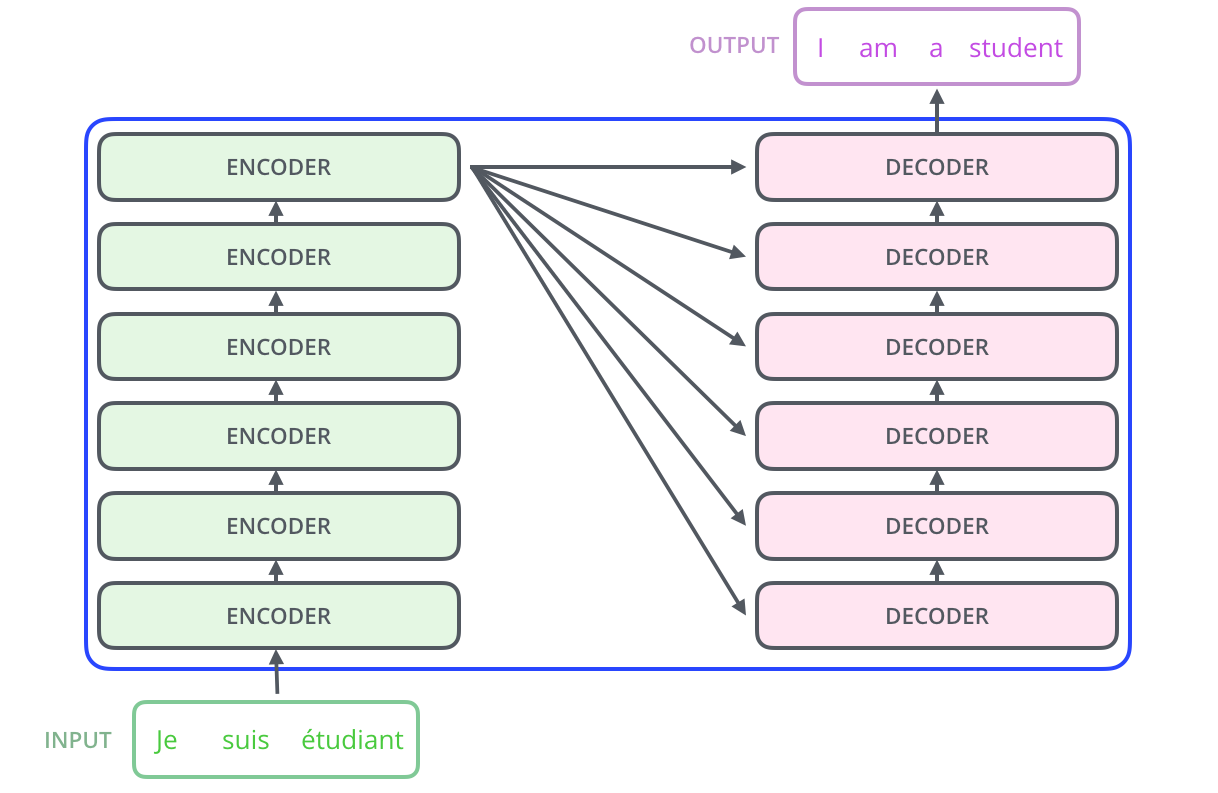

In [13]:
from IPython.display import Image
Image(filename='local/imgs/The_transformer_encoder_decoder_stack.png', width=600)

[Image taken from here](http://jalammar.github.io/illustrated-transformer/)

The explanation below is extracted from [here](http://jalammar.github.io/illustrated-transformer/) which is an excelent blog about Transformer. I recommend go to visit it for a more detailed explanation.

The encoder’s inputs first flow through a self-attention layer – a layer that helps the encoder look at other words in the input sentence as it encodes a specific word.

The outputs of the self-attention layer are fed to a feed-forward neural network. The exact same feed-forward network is independently applied to each position.

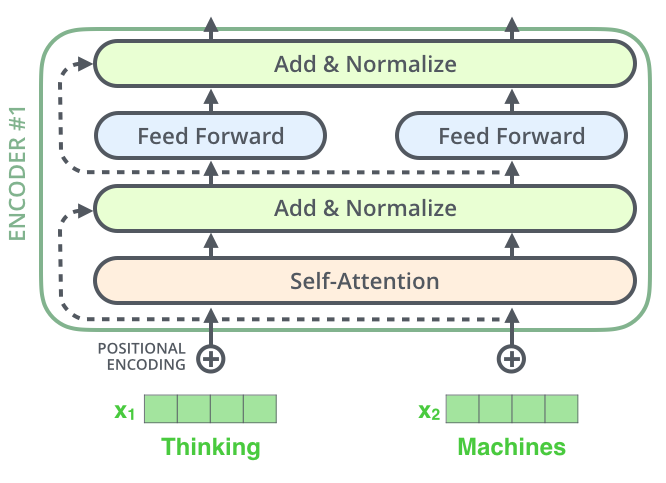

In [12]:
from IPython.display import Image
Image(filename='local/imgs/transformer_resideual_layer_norm.png', width=600)

### Self-attention

The first step in calculating self-attention is to create three vectors from each of the encoder's input vectors (in this case, the embedding of each word). So for each word, we create a **Query vector**, a **Key vector**, and a **Value vector**. These vectors are created by multiplying the embedding by three matrices that we trained during the training process.

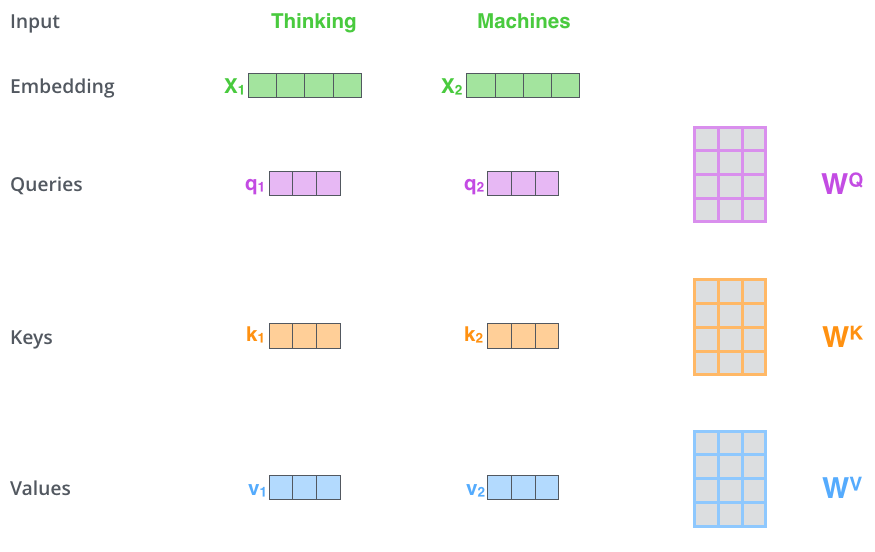

In [4]:
from IPython.display import Image
Image(filename='local/imgs/transformer_self_attention_vectors.png', width=800)

For each word in the sentence the self-attention module calculates a **score** with respecto to the other words in the sentece, by taking the dot product of the query vector with the key vector of the respective word it is scoring. The scores are pass trough a softmax function to normilize the scores so they are all positive and add up to 1.

The next step is to multiply each value vector by the softmax score (in preparation to sum them up). The intuition here is to keep intact the values of the word(s) we want to focus on, and drown-out irrelevant words (by multiplying them by tiny numbers like 0.001, for example).

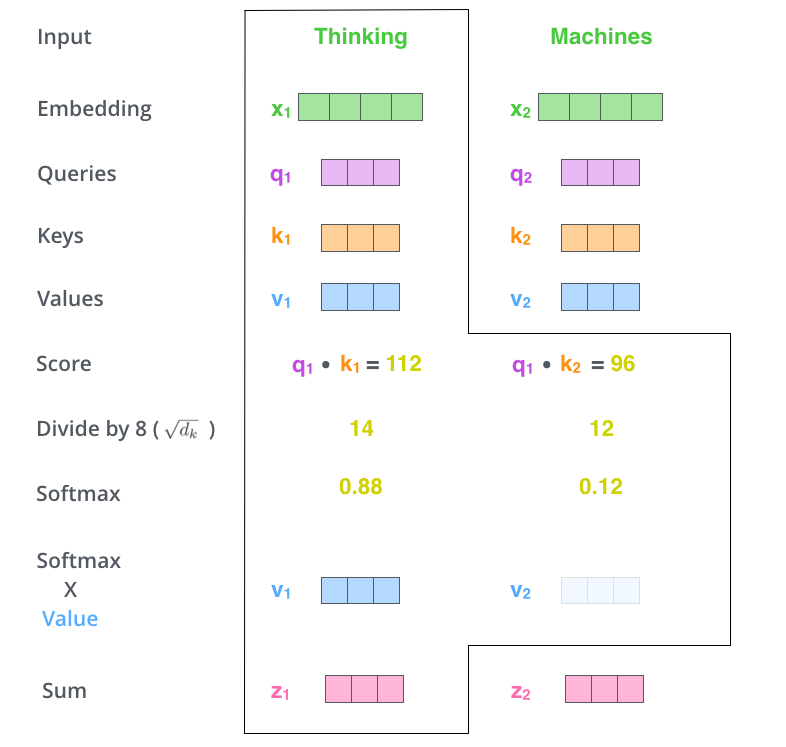

In [5]:
from IPython.display import Image
Image(filename='local/imgs/self-attention-output.png', width=800)

Similar to kernels in CNN, the former process is repited 8 times which is call a multi-headed self-attention, so in the end there are 8 $\bf{Z}$ matrices, so the final output is actually the product of an additional ${\bf{W}}^O$ matrix with the concatenation of all the $\bf{Z}$ matrices.

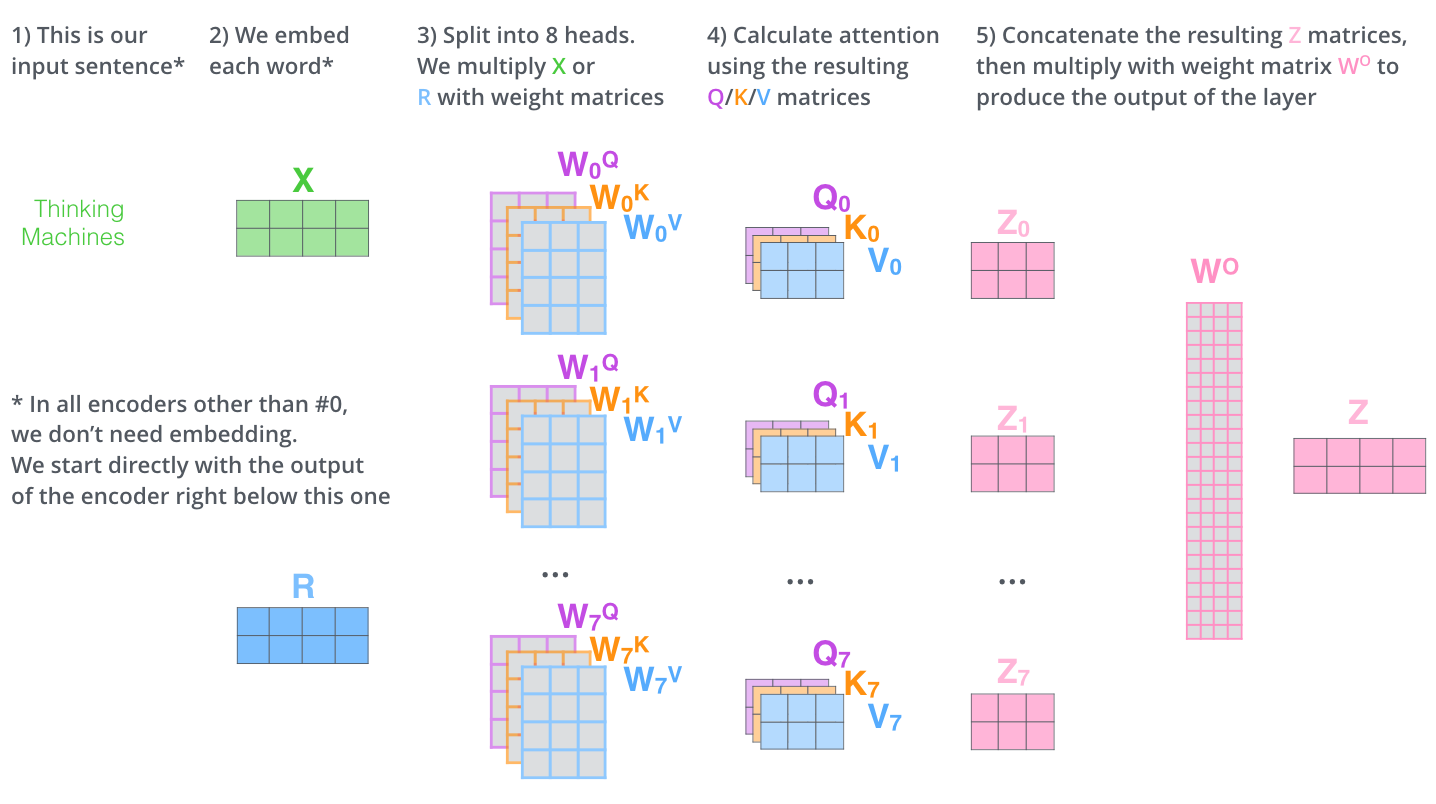

In [6]:
from IPython.display import Image
Image(filename='local/imgs/transformer_multi-headed_self-attention-recap.png', width=800)

Including the residual conections the encoder looks like:

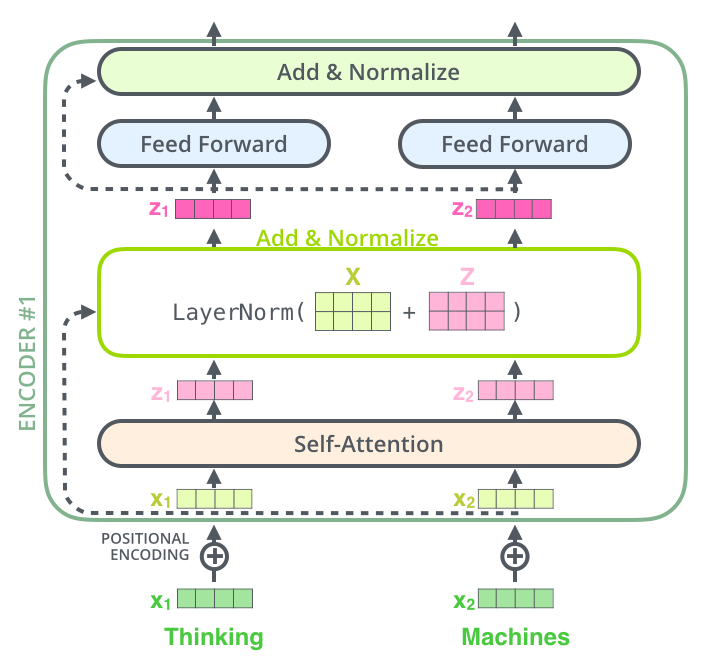

In [8]:
Image(filename='local/imgs/transformer_resideual_layer_norm_2.png', width=600)

**Note:**

The positional encoding is aiming to provide positional information (word order) to the network. The positional embeddings can be learned during trained phase or fixed; they can also be defined in absolute or relative terms, which modifie how the matrices of query, key, and value weights are used to calculate attention in
each attention head. A deep explanation of this component can be found in: [ON POSITION EMBEDDINGS IN BERT](https://openreview.net/pdf?id=onxoVA9FxMw), and also I recommend this [video](https://www.youtube.com/watch?v=dichIcUZfOw) that covers position embeddings in great depth.

Now we can take a look to the Decoder module. The decoder operates similarly, but generates one word at a time, from left to right. It attends not only to the other previously generated words, but also to the final representations generated by the encoder.

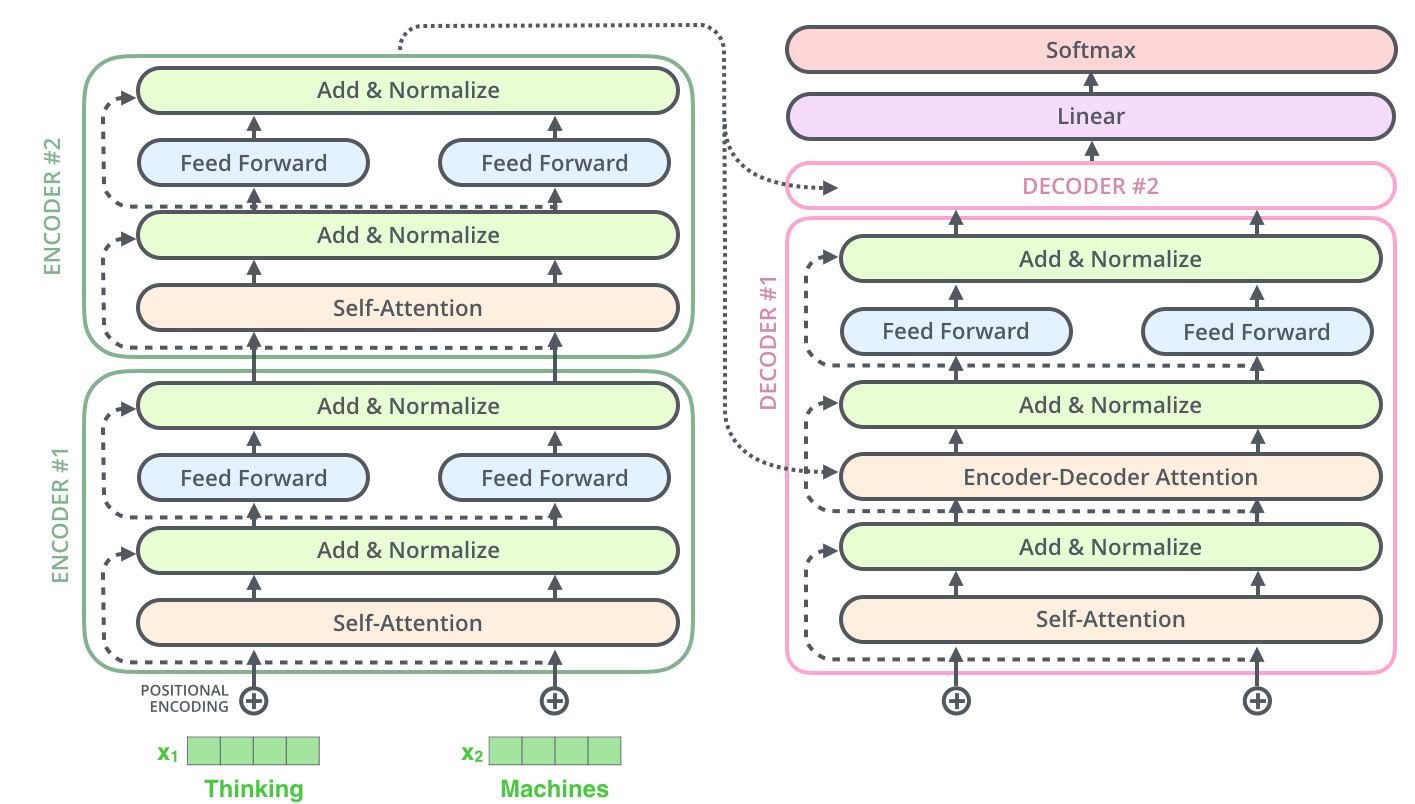

In [11]:
Image(filename='local/imgs/transformer_resideual_layer_norm_3.png', width=600)

The encoder start by processing the input sequence. The output of the top encoder is then transformed into a set of attention vectors $K$ and $V$. These are to be used by each decoder in its “encoder-decoder attention” layer which helps the decoder focus on appropriate places in the input sequence.

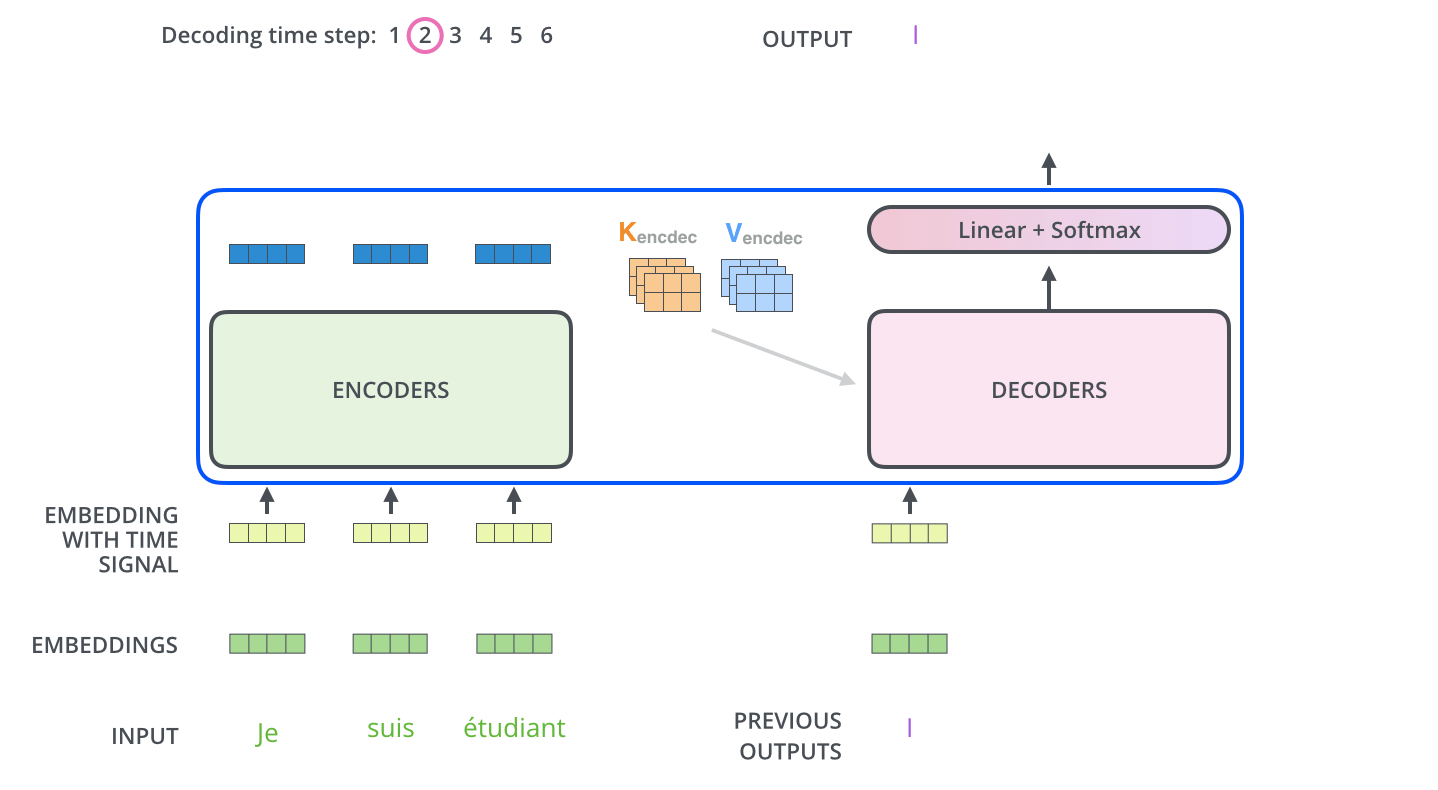

In [15]:
Image(filename='local/imgs/transformer_decoding_2.gif', width=800)

### Example: Sentiment analysis using a transformer block

One transformer block can be used as different type of embedding layer, and other architectures can be implemented on top of it.  In the following example we are going to use an architecture based on a transformer block to solve a moview review sentiment analysis problem. The dataset is included in the keras dataset module: [IMDB movie review sentiment classification dataset](https://keras.io/api/datasets/imdb/). This example is based on the one by [Apoorv Nandan](https://keras.io/examples/nlp/text_classification_with_transformer/). 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
25000 Training sequences
25000 Validation sequences


In [3]:
x_train[0]

array([    5,    25,   100,    43,   838,   112,    50,   670,     2,
           9,    35,   480,   284,     5,   150,     4,   172,   112,
         167,     2,   336,   385,    39,     4,   172,  4536,  1111,
          17,   546,    38,    13,   447,     4,   192,    50,    16,
           6,   147,  2025,    19,    14,    22,     4,  1920,  4613,
         469,     4,    22,    71,    87,    12,    16,    43,   530,
          38,    76,    15,    13,  1247,     4,    22,    17,   515,
          17,    12,    16,   626,    18, 19193,     5,    62,   386,
          12,     8,   316,     8,   106,     5,     4,  2223,  5244,
          16,   480,    66,  3785,    33,     4,   130,    12,    16,
          38,   619,     5,    25,   124,    51,    36,   135,    48,
          25,  1415,    33,     6,    22,    12,   215,    28,    77,
          52,     5,    14,   407,    16,    82, 10311,     8,     4,
         107,   117,  5952,    15,   256,     4,     2,     7,  3766,
           5,   723,

In [16]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=True):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [17]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [18]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [19]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=32, epochs=3, validation_data=(x_val, y_val))

Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.6886 - loss: 0.5342 - val_accuracy: 0.8820 - val_loss: 0.2861
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.9320 - loss: 0.1892 - val_accuracy: 0.8733 - val_loss: 0.3126
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.9635 - loss: 0.1129 - val_accuracy: 0.8639 - val_loss: 0.3876


## BERT 

Bidirectional Encoder Representations from Transformers

BERT's key technical innovation is applying the bidirectional training of Transformer [BERT](https://arxiv.org/pdf/1810.04805.pdf). The paper's results show that a language model which is bidirectionally trained can have a deeper sense of language context and flow than single-direction language models.

The algorithm proposed by the authors is called **"masked  language  model"  (MLM)** and uses only the encoder part of the transformer. In order to train a deep bidirectional representation, MLM simply mask some percentage of the input tokens at random, and then predict those masked tokens.

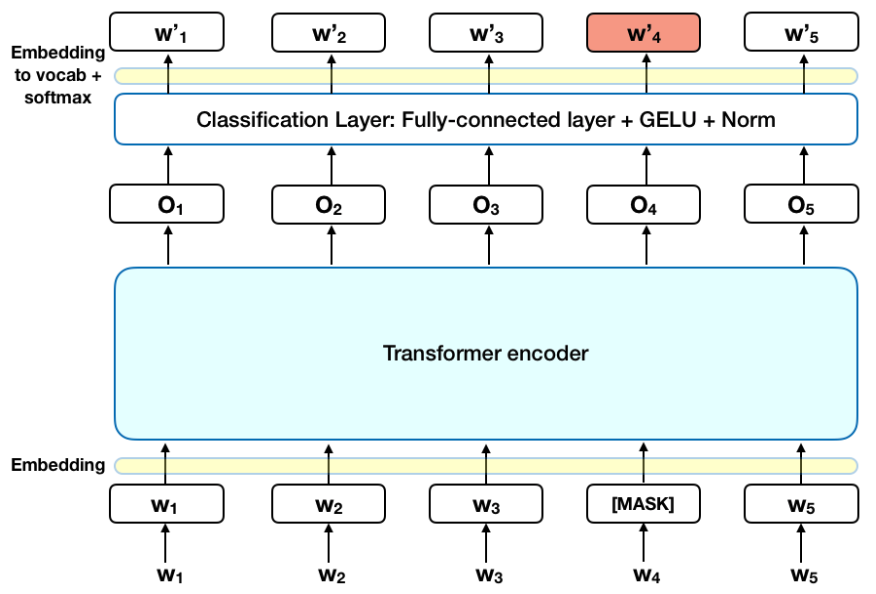

In [16]:
Image(filename='local/imgs/BERT.png', width=800)

[Image taken from here](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)

<div class="alert alert-block alert-info"><b>Note on GELU:</b>
    
    
<a href="https://arxiv.org/pdf/1606.08415.pdf">Gaussian Error Linear Units (GELU)</a> $GELU= xP(X\leq x) = 0.5x\left(1+ \text{erf} \left(\frac{x}{\sqrt{2}}\right) \right)$

The paper claims the increased curvature and non-monotonicity may allow GeLU to approximate complex function easier than ReLU or ELU.

</div>

There is a second phase in the training which is called **Sentence Prediction (NSP)** where the model is traned to predict if two sentences $A$ and $B$ are consecutive or not. Specifically, when choosing the sentences $A$ and $B$ for each pre-training example, 50% of the time $B$ is the actual next sentence that follows $A$, and 50% of the time it is a random sentence from the  corpus. 

By denoting  the  number  of  layers (i.e., Transformer blocks) as $L$, the hidden size as $H$, and the number of self-attention heads as $A$, the original paper purposes two architectures: ${\bf{BERT}}_{\text{BASE}}$ (L=12,  H=768,  A=12,  Total  Param-eters=110M)  and ${\bf{BERT}}_{\text{LARGE}}$ (L=24,  H=1024,A=16, Total Parameters=340M).

<div class="alert alert-block alert-success"><b>Variants of BERT:</b>

There are many variants of BERT, several proposed in 2019 (more than 170 papers), including new models, specific domain models, compressed BERT, and many others. Interesting readinsg:  

- [2019: The Year of BERT](https://towardsdatascience.com/2019-the-year-of-bert-354e8106f7ba)
- [A review of BERT based models](https://towardsdatascience.com/a-review-of-bert-based-models-4ffdc0f15d58)
    
</div>